#Classificação de Redes
##SME 0130 - Redes Complexas 1s/2021

###Bruno Gazoni 7585037 <br> Bruno Baldissera Carlotto 10724351 <br> Luis Gustavo Peçanha 9806763 <br> Sergio Carrazzoni de Toledo Piza 9361073 <br> Rafael Ceneme 9898610


Selecione 3 redes biológicas, 3 redes sociais e 3 redes tecnológicas desses endereços:

https://networks.skewed.de

http://konect.cc/networks/

https://icon.colorado.edu/


Faça a classificação das redes usando os modelos e medidas que aprendemos na aula.

Não se esqueça de selecionar o mesmo N e grau médio que a rede original na construção
dos modelos.

Verifique qual o modelo mais adequado para cada rede.

Hipótese: redes do mesmo tipo seguem o mesmo modelo.

Verifique se essa hipótese é verdadeira.

Bônus (não é obrigatório): identifique as principais diferenças entre os modelos. Isto é,
quais medidas mais contribuem para que uma rede seja classificada como sendo do
modelo BA.

minhas anotações sobre a aula:

- motivação: reproduzir topologia da rede real para ver como ela evolui futuramente

- gerar conjunto de treinamento com várias redes dos mesmos modelos -> classificador aprende com as medidas deles -> aplica no método de classificação -> bota rede no classificador

- classificador de menor distância KNN: pega moda dos knn

- pode usar outro método se quiser

- algoritmo:
i) gerar várias redes de um modelo
ii) criar matriz de atributos (cada coluna uma das medidas)
iii) pre-processing:
normalizar cada medida (z-score)
iv) treinamento do knn
v) classificação
vi) fazer uma análise da classificação pra ver se faz sentido (comparar matrizes)

links chicão:

https://www.youtube.com/watch?v=7WySJWL2o_4&t=169s&ab_channel=FranciscoRodrigues

https://drive.google.com/file/d/1EVlXNXNYLI-WtD8ibk150aW1KdSkZ9-d/view -> a partir de 25:34

https://edisciplinas.usp.br/pluginfile.php/6308244/mod_resource/content/1/costa2010.pdf

#To-do:

- achar 9 redes pra classificar e testar a hipótese

- adicionar mais medidas

- adicionar mais modelos

_____________________________________________

- implementar k-folds para achar melhor k
  - https://towardsdatascience.com/cross-validation-using-knn-6babb6e619c8

- adicionar como referências o código original do moodle e o artigo do chicão e outras coisas pelo caminho

#Bônus:

- encontrar atributos que tiveram maior impacto na classificação

- ideia: features com maior variância são mais discriminativas
- Lasso regularization: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
  - PCA, random forest, árvore de decisão...

------------------------------------------------------------------------

# Imports

In [132]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Functions

In [133]:
def load_network(path):
  """
    Loads network given network path.

  args:
    network_path (String): Path to file containing network
  """

  G = nx.read_edgelist(path, delimiter=',', nodetype=int, data=(('weight',float),))
  G = G.to_undirected()
  G.remove_edges_from(nx.selfloop_edges(G))
  print(G)
  Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gcc[0])
  G = nx.convert_node_labels_to_integers(G, first_label=0)

  return G

In [134]:
def visualize_network(G, i, title):
  """
    Shows visualization of network and prints the number of nodes and edges within it. 

  args:
    G (graph): Network to show. 
  """

  '''N = len(G)
  M = G.number_of_edges()
  print('Number of nodes:', N)
  print('Number of edges:', M)'''

  pos = nx.spring_layout(G)
  plt.subplot(i); plt.title(title)
  nx.draw(G, pos, node_color="b", node_size=1, with_labels=False)

In [135]:
def moment_of_degree_distribution(G, m):
  """
    Calculates moment of degree distribution for network G.

  args:
    G (graph): Network where moment of degree will be calculated.
    m (int):   The degree that will be calculated.  
  """
  M = 0
  N = len(G)
  for i in G.nodes:
        M = M + G.degree(i)**m
  M = M/N

  return M

In [136]:
def shannon_entropy(G):
    """
        Calculates shannon entropy for network G.

        args:
            G (graph): Network where shannon entropy will be calculated.
    """
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H

In [137]:
def complexity_coef(G):
  """
    Calculates complexity coefficient for network G.

  args:
    G (graph): Network where complexity coefficient will be calculated.
  """

  cx = (moment_of_degree_distribution(G, 2) / moment_of_degree_distribution(G, 1))
  
  return cx

In [138]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values()) # we get only the degree values
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

In [139]:
#medidas para redes:
#primeiro e segundo momentos, variância, average clustering,
#caminho mais curto médio, assortatividade

#adicionar mais medidas!

"""
      Calculates measures of the network G. 

    args:
      G (graph): Network where measures will be calculated.
"""
def measures(G):
    measures = []

    #print("iniciando measures")
    # n de nos
    N = len(G)
    # n de arestas
    M = G.number_of_edges()
    # densidade
    den = N/M
    measures.append(den)

    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)

    #print("diametro")
    # diametro da rede
    d = nx.diameter(G)
    measures.append(d)

    #print("eficiencia global")
    # eficiencia global
    eg = nx.global_efficiency(G)
    measures.append(eg)

    #print("eficiencia local")
    # eficiencia local
    el = nx.local_efficiency(G)
    measures.append(el)

    #print("closeness centrality")
    # closeness centrality media
    CLC = dict(nx.closeness_centrality(G))
    CLC = list(CLC.values())
    av_clc = np.mean(CLC)
    measures.append(av_clc)

    #print("betweenness centrality")
    # betweenness media
    B = dict(nx.betweenness_centrality(G))
    B = list(B.values())
    av_b = np.mean(B)
    measures.append(av_b)

    # centralidade de autovalor
    # EC = dict(nx.eigenvector_centrality(G, max_iter = 1000))
    # EC = list(EC.values())
    # av_ec = np.mean(EC)

    #print("pagerank medio")
    # pagerank medio
    PR = dict(nx.pagerank(G, alpha=0.85))
    PR = list(PR.values())
    av_pr = np.mean(PR)
    measures.append(av_pr)

    #print("k1 k2 k3")
    # 1o, 2o e 3o momentos de distribuição de grau
    k1 = moment_of_degree_distribution(G,1)
    k2 = moment_of_degree_distribution(G,2)
    k3 = moment_of_degree_distribution(G,3)
    measures.append(k1)
    measures.append(k2)
    measures.append(k3)

    #print("variancia")
    # variancia da distribuição de grau
    var = k2 - k1**2
    measures.append(var)

    #print("clustering medio")
    # clustering medio
    av_cl = nx.average_clustering(G)
    measures.append(av_cl)

    #print("menor caminho medio")
    # menor caminho medio
    l = nx.average_shortest_path_length(G)
    measures.append(l)

    #print("coef assortatividade")
    # coeficiente de assortatividade
    r = nx.degree_assortativity_coefficient(G)
    if math.isnan(r):
        r = 0
    measures.append(r)

    #print("shannon")
    # entropia de shannon
    se = shannon_entropy(G)
    measures.append(se)

    #print("complexidade")
    # coeficiente de complexidade
    cx = complexity_coef(G)
    measures.append(cx)

    #print("transitividade")
    # transitividade
    t = nx.transitivity(G)
    measures.append(t)

    #tiramos av_ec
     #den, d, eg, el, av_clc, k1, k2, k3, variance, av_cl, av_b, l, r, se, cx, t
    return measures

# Main


## Network 1


## Network 2

## Network 3

In [140]:
#geradores de redes
#aqui está gerando 30 redes de cada tipo
#atenção! N aqui é igual ao N da rede a ser classificada e grau médio = k1 anterior

#conferir se há mais modelos para gerar: quanto mais modelos melhor
#tentar implementar os modelos espaciais. voronoy não precisa que é muito treta o grau médio
#tentar axman, etc

def generate_trainset(n_nets, k1, N):
  count = 0
  cl = ['ER','WS','BA','WG']
  #ER networks (Erdos Renyi random graph)
  X = []
  y = []
  #n_nets = 30
  av_degree = k1
  p = av_degree/(N-1)

  for i in range(0,n_nets):
      GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
      Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
      GER = GER.subgraph(Gcc[0])
      GER = nx.convert_node_labels_to_integers(GER, first_label=0)
      x = measures(GER)
      X.append(x)
      y.append(0.0)
      count += 1
      print(f"ER {i} ", end='')

  #WS networks (Watts and Strogatz small-world model)
  k = int(av_degree)
  p = 0.1 #probability of rewiring
  for i in range(0,n_nets):
      GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
      Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
      GWS = GWS.subgraph(Gcc[0])
      GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
      x = measures(GWS)
      X.append(x)
      y.append(1.0)
      count += 1
      print(f"WS {i} ", end='')

  # BA networks (Barabasi and Albert scale-free model)
  m = int(av_degree/2)
  for i in range(0,n_nets):
      GBA = nx.barabasi_albert_graph(N, m)
      Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
      GBA = GBA.subgraph(Gcc[0])
      GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
      x = measures(GWS)
      X.append(x)
      y.append(2.0)
      count += 1
      print(f"BA {i} ", end='')

  # WG (Waxman random graph)
  for i in range(0, n_nets):
      GWG = nx.generators.geometric.waxman_graph(N)
      Gcc = sorted(nx.connected_components(GWG), key=len, reverse=True)
      GWG = GWG.subgraph(Gcc[0])
      x = measures(GWG)
      X.append(x)
      y.append(3.0)
      count += 1
      print(f"WG {i} ", end='')

  #matrizes de atributos
  X = np.array(X)
  y = np.array(y)

  print("")

  return X, y

In [141]:
#normalização e knn
def KNNclassifier(X, X_net, y, k=5):
  scaler = StandardScaler().fit(X)
  X = scaler.transform(X)

  X_net = np.array(X_net)
  X_net = X_net.reshape(1,len(X_net)) 
  X_net = scaler.transform(X_net)
  #print('Xnet:', X_net.shape)

  model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
  model.fit(X,y)
  return model, scaler
  # faz a predição no conjunto de teste

In [142]:
def randomForestClassifier(X, X_net, y, maxDepth=4):
  y = y.astype(int)
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.datasets import make_classification

  print(f"maxdepth {maxDepth} ", end='')

  scaler = StandardScaler().fit(X)
  X = scaler.transform(X)

  X_net = np.array(X_net)
  X_net = X_net.reshape(1,len(X_net)) 
  X_net = scaler.transform(X_net)

  clf = RandomForestClassifier(max_depth=maxDepth, random_state=0)
  clf.fit(X, y)
  return clf, scaler

In [143]:
#predição
def predict(X_net, model, scaler):

  cl = ['ER','WS','BA','WG']

  #print("normalizando X_net")
  X_net = np.array(X_net)
  #print("reshaping")
  X_net = X_net.reshape(1,len(X_net))
  #print("scaling")
  X_net = scaler.transform(X_net)

  #print('Xnet:', X_net.shape)
  y_pred = model.predict(X_net) 
  #print('Classe:', cl[int(y_pred)])
  return int(y_pred)

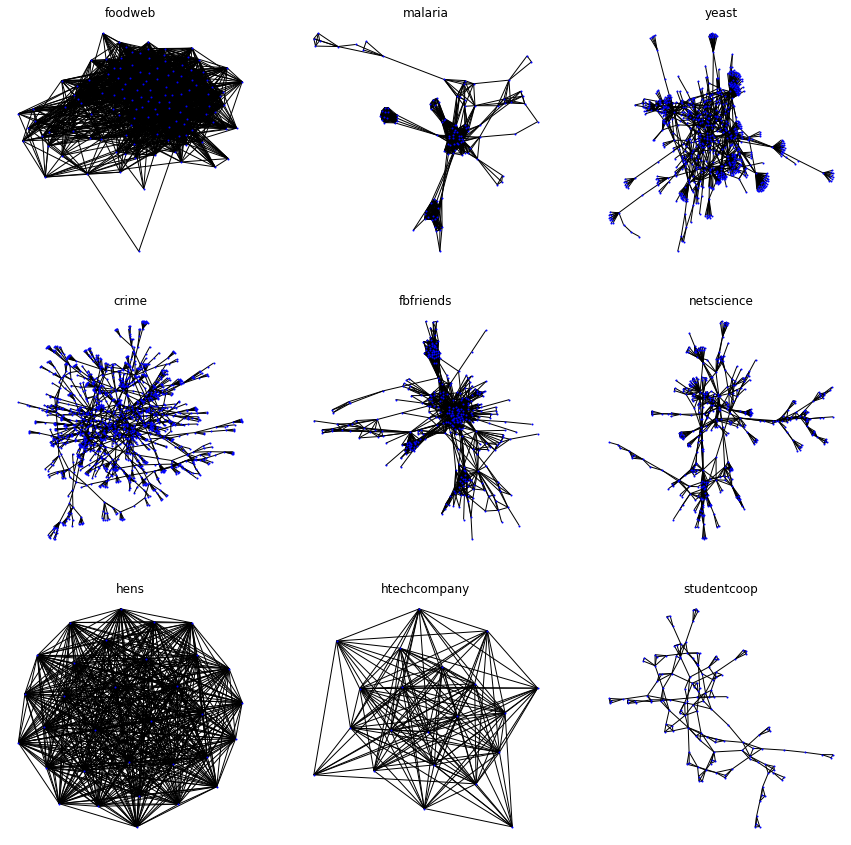

In [144]:
# Importando redes para teste

# Biológicas
plt.figure(figsize=(15,15))
b1 = load_network("/content/networks/bio/foodweb_baywet.csv")
visualize_network(b1,331, "foodweb")
b2 = load_network("/content/networks/bio/malaria_genes.csv")
visualize_network(b2,332, "malaria")
b3 = load_network("/content/networks/bio/yeast_transcription.csv")
visualize_network(b3,333, "yeast")

# Sociais
s1 = load_network("/content/networks/social/crime.csv")
visualize_network(s1,334, "crime")
s2 = load_network("/content/networks/social/facebook_friends.csv")
visualize_network(s2,335, "fbfriends")
s3 = load_network("/content/networks/social/netscience.csv")
visualize_network(s3,336, "netscience")

# Tecnológicas
t1 = load_network("/content/networks/tech/hens.csv")
visualize_network(t1,337, "hens")
t2 = load_network("/content/networks/tech/high_tech_company.csv")
visualize_network(t2,338, "htechcompany")
t3 = load_network("/content/networks/tech/student_cooperation.csv")
visualize_network(t3,339, "studentcoop")

plt.show()


In [145]:
b1_net = measures(b1)
b1X, b1Y = generate_trainset(30, b1_net[7], len(b1))
b2_net = measures(b2)
b2X, b2Y = generate_trainset(30, b2_net[7], len(b2))
b3_net = measures(b3)
b3X, b3Y = generate_trainset(30, b3_net[7], len(b3))

s1_net = measures(s1)
s1X, s1Y = generate_trainset(30, s1_net[7], len(s1))
s2_net = measures(s2)
s2X, s2Y = generate_trainset(30, s2_net[7], len(s2))
s3_net = measures(s3)
s3X, s3Y = generate_trainset(30, s3_net[7], len(s3))

t1_net = measures(t1)
t1X, t1Y = generate_trainset(30, t1_net[7], len(t1))
t2_net = measures(t2)
t2X, t2Y = generate_trainset(30, t2_net[7], len(t2))
t3_net = measures(t3)
t3X, t3Y = generate_trainset(30, t3_net[7], len(t3))

#print(X, y)

ER 0 ER 1 ER 2 ER 3 ER 4 ER 5 ER 6 ER 7 ER 8 ER 9 ER 10 ER 11 ER 12 ER 13 ER 14 ER 15 ER 16 ER 17 ER 18 ER 19 ER 20 ER 21 ER 22 ER 23 ER 24 ER 25 ER 26 ER 27 ER 28 ER 29 WS 0 WS 1 WS 2 WS 3 WS 4 WS 5 WS 6 WS 7 WS 8 WS 9 WS 10 WS 11 WS 12 WS 13 WS 14 WS 15 WS 16 WS 17 WS 18 WS 19 WS 20 WS 21 WS 22 WS 23 WS 24 WS 25 WS 26 WS 27 WS 28 WS 29 BA 0 BA 1 BA 2 BA 3 BA 4 BA 5 BA 6 BA 7 BA 8 BA 9 BA 10 BA 11 BA 12 BA 13 BA 14 BA 15 BA 16 BA 17 BA 18 BA 19 BA 20 BA 21 BA 22 BA 23 BA 24 BA 25 BA 26 BA 27 BA 28 BA 29 WG 0 WG 1 WG 2 WG 3 WG 4 WG 5 WG 6 WG 7 WG 8 WG 9 WG 10 WG 11 WG 12 WG 13 WG 14 WG 15 WG 16 WG 17 WG 18 WG 19 WG 20 WG 21 WG 22 WG 23 WG 24 WG 25 WG 26 WG 27 WG 28 WG 29 
ER 0 ER 1 ER 2 ER 3 ER 4 ER 5 ER 6 ER 7 ER 8 ER 9 ER 10 ER 11 ER 12 ER 13 ER 14 ER 15 ER 16 ER 17 ER 18 ER 19 ER 20 ER 21 ER 22 ER 23 ER 24 ER 25 ER 26 ER 27 ER 28 ER 29 WS 0 WS 1 WS 2 WS 3 WS 4 WS 5 WS 6 WS 7 WS 8 WS 9 WS 10 WS 11 WS 12 WS 13 WS 14 WS 15 WS 16 WS 17 WS 18 WS 19 WS 20 WS 21 WS 22 WS 23 WS 24 WS 25 WS 

/usr/local/lib/python3.7/dist-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


ER 0 ER 1 ER 2 ER 3 ER 4 ER 5 ER 6 ER 7 ER 8 ER 9 ER 10 ER 11 ER 12 ER 13 ER 14 ER 15 ER 16 ER 17 ER 18 ER 19 ER 20 ER 21 ER 22 ER 23 ER 24 ER 25 ER 26 ER 27 ER 28 ER 29 WS 0 WS 1 WS 2 WS 3 WS 4 WS 5 WS 6 WS 7 WS 8 WS 9 WS 10 WS 11 WS 12 WS 13 WS 14 WS 15 WS 16 WS 17 WS 18 WS 19 WS 20 WS 21 WS 22 WS 23 WS 24 WS 25 WS 26 WS 27 WS 28 WS 29 BA 0 BA 1 BA 2 BA 3 BA 4 BA 5 BA 6 BA 7 BA 8 BA 9 BA 10 BA 11 BA 12 BA 13 BA 14 BA 15 BA 16 BA 17 BA 18 BA 19 BA 20 BA 21 BA 22 BA 23 BA 24 BA 25 BA 26 BA 27 BA 28 BA 29 WG 0 WG 1 WG 2 WG 3 WG 4 WG 5 WG 6 WG 7 WG 8 WG 9 WG 10 WG 11 WG 12 WG 13 WG 14 WG 15 WG 16 WG 17 WG 18 WG 19 WG 20 WG 21 WG 22 WG 23 WG 24 WG 25 WG 26 WG 27 WG 28 WG 29 
ER 0 ER 1 ER 2 ER 3 ER 4 ER 5 ER 6 ER 7 ER 8 ER 9 ER 10 ER 11 ER 12 ER 13 ER 14 ER 15 ER 16 ER 17 ER 18 ER 19 ER 20 ER 21 ER 22 ER 23 ER 24 ER 25 ER 26 ER 27 ER 28 ER 29 WS 0 WS 1 WS 2 WS 3 WS 4 WS 5 WS 6 WS 7 WS 8 WS 9 WS 10 WS 11 WS 12 WS 13 WS 14 WS 15 WS 16 WS 17 WS 18 WS 19 WS 20 WS 21 WS 22 WS 23 WS 24 WS 25 WS 

#Random Forest

In [146]:

def random_forest(X_net, X, y, name):
  #substituí r por 0
  #X_net = [den, d, eg, el, av_clc, k1, k2, k3, variance, av_cl, av_b, l, 0, se, cx, t]
  model, scaler = randomForestClassifier(X, X_net, y, 5)
  cl = ['ER','WS','BA','WG']

  prediction = predict(X_net, model, scaler)
  print('Classe random forest:', name, cl[int(prediction)])

  rAcclist = []

  importances = model.feature_importances_
  measurements_list = ["den", "d", "eg", "el", "av_clc", "k1", "k2", "k3", 
                      "variance", "av_cl", "av_b", "l", "r", "se", "cx", "t"]
  importances_list = []

  for i in range(0, 16):
    importances_list.append([measurements_list[i], importances[i]])

  from operator import itemgetter
  print(sorted(importances_list, key=itemgetter(1)))


#KNN

In [147]:
def apply_knn(X_net, X, y, name):  
  #print(f"o sheipe de xiszao eh {X.shape}")
  #substituí r por 0
  #X_net = [den, d, eg, el, av_clc, k1, k2, k3, variance, av_cl, av_b, l, 0, se, cx, t]
  y = y.astype(int)
  model, scaler = KNNclassifier(X, X_net, y, 4)

  #print(X_net)

  cl = ['ER','WS','BA','WG']

  prediction = predict(X_net, model, scaler)
  print('Classe knn:', name, cl[int(prediction)])

  #iteraremos por K diferentes para descobrir o óptimo

  acclist = []

  best_k = 0
  last_acc = 0.0

  for k in range (1, int(X.shape[0]/2)):
    classlist = []
    for i in range(0, X.shape[0]):
      currTrain = np.delete(X, i, 0)
      model, scaler = KNNclassifier(X, X_net, y, k)
      currclass = predict(X[i], model, scaler)
      classlist.append(currclass)
    #print(len(classlist))
    #print(y.shape)
    acc = accuracy_score(y, classlist)
    acclist.append(acc)
    if (acc > last_acc):
      best_k = k
    last_acc = acc

    print(f"sabemos:{y}")
    print(f"re-classificamos:{classlist}")

    print(f"acc para k igual a {k} é {acc}")

  model, scaler = KNNclassifier(X, X_net, y, best_k)
  prediction = predict(X_net, model, scaler)
  print('Classe knn (com melhor k):', name, cl[int(prediction)])

In [148]:
# bio
random_forest(b1_net, b1X, b1Y, "foodweb")
random_forest(b2_net, b2X, b2Y, "malaria")
random_forest(b3_net, b3X, b3Y, "yeast")

# social
random_forest(s1_net, s1X, s1Y, "crime")
random_forest(s2_net, s2X, s2Y, "fbfriends")
random_forest(s3_net, s3X, s3Y, "netscience")

# tech
random_forest(t1_net, t1X, t1Y, "hens")
random_forest(t2_net, t2X, t2Y, "htechcompany")
random_forest(t3_net, t3X, t3Y, "studentcoop")

print("###################################")

# bio
apply_knn(b1_net, b1X, b1Y, "foodweb")
apply_knn(b2_net, b2X, b2Y, "malaria")
apply_knn(b3_net, b3X, b3Y, "yeast")

# social
apply_knn(s1_net, s1X, s1Y, "crime")
apply_knn(s2_net, s2X, s2Y, "fbfriends")
apply_knn(s3_net, s3X, s3Y, "netscience")

# tech
apply_knn(t1_net, t1X, t1Y, "hens")
apply_knn(t2_net, t2X, t2Y, "htechcompany")
apply_knn(t3_net, t3X, t3Y, "studentcoop")

maxdepth 5 Classe random forest: foodweb ER
[['se', 0.014627680649568393], ['d', 0.016158187662767852], ['k3', 0.028122056996517986], ['den', 0.03196670187646398], ['k2', 0.035074699778989686], ['cx', 0.036368031903334104], ['variance', 0.04816458480003879], ['av_b', 0.050027738180299736], ['t', 0.056723629107358155], ['av_cl', 0.05812339493925672], ['l', 0.058437008721649364], ['av_clc', 0.09462559098937], ['r', 0.09805616133294112], ['el', 0.10245766997978442], ['k1', 0.10319180228300591], ['eg', 0.11069583545064009]]
maxdepth 5 Classe random forest: malaria ER
[['d', 0.01598011489613972], ['av_b', 0.03833720210130521], ['k3', 0.038526985256957864], ['k2', 0.03938850059539376], ['l', 0.04144742050472224], ['den', 0.04783517080483036], ['t', 0.04882482518119575], ['se', 0.04956017328342579], ['el', 0.061897277989975893], ['variance', 0.064704755104223], ['cx', 0.07333046683969265], ['av_cl', 0.07748398365531438], ['av_clc', 0.08508999596257623], ['k1', 0.08760441618641529], ['r', 0.08


#Referências